**Visual Agentic AI**

In [9]:
!pip install -U langchain==0.3.24 langchain-openai==0.3.14 langgraph==0.3.33 langchain-tavily==0.1.6


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"] = "LANGCHAIN_API_KEY"
os.environ["LANGCHAIN_PROJECT"] = "Visual-Agentic-AI"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["TAVILY_API_KEY"] = "TavilyAPIKey"
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

In [12]:
from langchain_tavily  import TavilySearch

web_search =  TavilySearch(max_results=5)



In [13]:
web_search_results = web_search.invoke("What is the temperature of Vietnam?")

print(web_search_results["results"][0]["content"])


Overview of Vietnam Weather. Average temperature: 27 °C (81 °F), varies by region and season. Average humidity: 84%, varies by region and season. Average rainfall: 1,800 mm (71 inches), varies by region and season. Average sunshine duration: 2,000 hours per year, varies by region and season Average wind speed: not available. Rainy Season: May to October in most of the country, influenced by


In [15]:
from langgraph.prebuilt import create_react_agent

research_agent= create_react_agent(
    model = "gpt-4o-mini",
    tools = [web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [17]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent = False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return
    intended = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(intended)

def pretty_print_messages(update, cast_message = False):
    is_subgraph = False
    if isinstance(update, tuple):
        namespace, update = update
        if len(namespace) == 0:
            return
        graph_id = namespace[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:\n")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:\n"
        if is_subgraph:
            update_label = "\t" + update_label
        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        for message in messages:
            pretty_print_message(message, indent = is_subgraph)
        print("\n") 


    



In [25]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "Who is the Mayor of NYC?"}]} 
):
    pretty_print_messages(chunk)

Update from node agent:



================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_nOm8hoh0qLahwcV3VolOv1Q5)
 Call ID: call_nOm8hoh0qLahwcV3VolOv1Q5
  Args:
    query: current Mayor of New York City
    search_depth: basic


Update from node tools:



================================= Tool Message =================================
Name: tavily_search

{"query": "current Mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Office of the Mayor | Mayor's Bio | City of New York - NYC.gov", "url": "https://www.nyc.gov/office-of-the-mayor/bio.page", "content": "Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. He gave voice to a diverse coalition of working families in all five boroughs and is leading the fight to bring back New York City's 

**Math Agent**

In [26]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b

In [27]:
math_agent = create_react_agent(
    model = "gpt-4o-mini",
    tools = [add, multiply, divide],
    prompt = (
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [31]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "What is 4 + 5?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:



================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_pEB4WudyG53jWxhsxfxrxrM7)
 Call ID: call_pEB4WudyG53jWxhsxfxrxrM7
  Args:
    a: 4
    b: 5


Update from node tools:



================================= Tool Message =================================
Name: add

9.0


Update from node agent:



================================== Ai Message ==================================
Name: math_agent

9.0




In [40]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model = init_chat_model("gpt-4o-mini"),
    agents = [math_agent, research_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

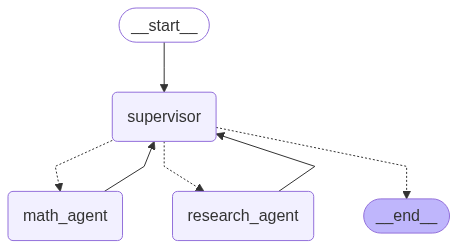

In [43]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [63]:
for chunk in supervisor.stream(
    {
        "messages" : [
            {
                "role" : "user",
                "content" : "What is the GPD of Vietnam in 2011, predict it in 2025 in billion USD?",

            }
        ]
    },  
    
):
    pretty_print_messages(chunk)

{'supervisor': {'messages': [HumanMessage(content='What is the GPD of Vietnam in 2011, predict it in 2025 in billion USD?', additional_kwargs={}, response_metadata={}, id='4d9f648c-5a4f-4885-8305-ca7b66f1ced7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_znKGWKCqhCAbxHpUp4N1ywiZ', 'function': {'arguments': '{}', 'name': 'transfer_to_math_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 141, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-BbMpONoNmF1c69fXQ6yAt07cnfFPk', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--af6a658c-4140-4f85-927e-7953d1028fd0-0', tool_calls=[{'name': 'transfer

***Multi Agent Supervisor***

In [76]:
pip install arxiv wikipedia duckduckgo-search

  Using cached wikipedia-1.4.0.tar.gz (27 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11703 sha256=b9db7e8e2cdd8c2fb8198a5e8235468cfcf3bf857beaa6eb1b989924e42bf8bd
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\8f\ab\cb\45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


**Search**

In [81]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun, DuckDuckGoSearchRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper, DuckDuckGoSearchAPIWrapper

In [82]:
DuckDuckGo_wrapper = DuckDuckGoSearchAPIWrapper()
DuckDuckGo = DuckDuckGoSearchRun(
    api_wrapper = DuckDuckGo_wrapper,
    description="Use this tool to search for information on the internet"
)
DuckDuckGo.invoke("What is the capital of France?")

    

'Paris is the capital of what country? Paris, city and capital of France, situated in the north-central part of the country. People were living on the site of the present-day city, located along the Seine River some 233 miles (375 km) upstream from the river\'s mouth on the English Channel (La Manche), by about 7600 bce. Learn about Paris, the capital and largest city of France, with its history, culture, landmarks, and transportation. Find out its location, population, currency, and weather in 2025. What is the French Capital of the World? The answer, unequivocally, is Paris. While the term "French capital of the world" isn\'t an official designation, it\'s a moniker that Paris has earned through its immense influence on global culture, fashion, art, cuisine, and politics. Learn why Paris is the capital of France and how it became the political and cultural hub of the country. Discover the best places to visit, the weather, the food, and the nicknames of the "City of Light" and the "C

In [72]:
arxiv_wrapper = ArxivAPIWrapper(
    top_k_result = 4,
    doc_content_chars_min = 0,
    doc_content_chars_max = 2000
)
arxiv = ArxivQueryRun(
    arxiv_wrapper = arxiv_wrapper,
    description="Use this tool to search for papers on arxiv.org"
)
arxiv.invoke("Rotary Positional Encoding")

'Published: 2025-03-03\nTitle: Rotary Outliers and Rotary Offset Features in Large Language Models\nAuthors: André Jonasson\nSummary: Transformer-based Large Language Models (LLMs) rely on positional encodings\nto provide sequence position information to their attention mechanism. Rotary\nPositional Encodings (RoPE), which encode relative position by rotating queries\nand keys, have become widely used in modern LLMs. We study the features and\npatterns that emerge in queries and keys when using rotary embeddings. Our\nanalysis reveals consistent patterns within the same model across layers and\nattention heads and across different models and architectures. We present and\napply analysis techniques and show how the queries and keys use RoPE to\nconstruct various attention patterns, including attention sinks. We find and\nanalyze outliers across models in queries and keys and find that they are\nlikely to be found in rotary features with partial cycles. We derive bounds\nthat tell us wha

In [79]:
wikipedia_wrapper = WikipediaAPIWrapper()
wikipedia = WikipediaQueryRun(
    api_wrapper = wikipedia_wrapper,
    description="Use this tool to search for information on wikipedia"
)
wikipedia.invoke("Deep Learning")

'Page: Deep learning\nSummary: Deep learning is a subset of machine learning that focuses on utilizing multilayered neural networks to perform tasks such as classification, regression, and representation learning. The field takes inspiration from biological neuroscience and is centered around stacking artificial neurons into layers and "training" them to process data. The adjective "deep" refers to the use of multiple layers (ranging from three to several hundred or thousands) in the network. Methods used can be either supervised, semi-supervised or unsupervised.\nSome common deep learning network architectures include fully connected networks, deep belief networks, recurrent neural networks, convolutional neural networks, generative adversarial networks, transformers, and neural radiance fields. These architectures have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image anal

In [198]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [91]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model = "gpt-4o-mini",
    tools = [arxiv, DuckDuckGo, wikipedia],
    prompt = ("you are a research agent.\n\n"
    "INSTRUCTIONS:\n"
    "1. Read the question carefully.\n"
    "2. Use the tools to find the answer.\n"
    "3. Return the answer.\n\n"),
    name = "research_agent",
)


In [92]:
config = {"recursion_limit": 10}
for chunk in research_agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is reinforcement learning?",
            }
        ]
    },
    config=config,
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  wikipedia (call_AHY1cqhPeSYR7NP8L1ZhjiUH)
 Call ID: call_AHY1cqhPeSYR7NP8L1ZhjiUH
  Args:
    query: Reinforcement Learning


Update from node tools:


================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning
Summary: Reinforcement learning (RL) is an interdisciplinary area of machine learning and optimal control concerned with how an intelligent agent should take actions in a dynamic environment in order to maximize a reward signal. Reinforcement learning is one of the three basic machine learning paradigms, alongside supervised learning and unsupervised learning.
Reinforcement learning differs from supervised learning in not needing labelled input-output pairs to be presented, and in not needing sub-optimal actions to be explicitly corrected. Instead, the focus is on finding 

**Visual Agent AI**



In [93]:
import base64

from torch import imag

def encode_image(image_path_or_url: str, get_nine_type: bool = False):
    if image_path_or_url.startswith("http"):
        try:
            response = requests.get(image_path_or_url)
            response.raise_for_status()
            image = response.content
            nine_type = response.headers.get("Content-Type", None)
            base64_encode = base64.b64encode(image).decode("utf-8")
            if get_nine_type:
                return base64_encode, nine_type
            return base64_encode
        except requests.exceptions.RequestException as e:
            print(f"Request_error: {e}")
            if get_nine_type:
                return None, None
            return None
    else:
        try:
            nine_type = magic.Magic(mime=True).from_file(image_path_or_url)
            if nine_type.startswith("image/"):
                with open(image_path_or_url, "rb") as f:
                    image = f.read()
                    base64_encode = base64.b64encode(image).decode("utf-8")
                    if get_nine_type:
                        return base64_encode, None
                return base64_encode
        except Exception as e:
            print(f"File_error: {e}")
            if get_nine_type:
                return None, None
            return None
    

**URL Extractor**

In [109]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano")

In [110]:
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field

class ImageInput(BaseModel):
    image_path_or_url: str = Field(description="Path to image or URL")

parser = PydanticOutputParser(pydantic_object=ImageInput)

prompt = PromptTemplate.from_template(
    "Extract the image path or URL from the following input:\n\n{input}\n\n{format_instructions}"
).partial(format_instructions=parser.get_format_instructions())

extractor_chain = prompt | llm | parser
output = extractor_chain.invoke({"input": 'image_path: "https://example.com/image.png"'})
output

ImageInput(image_path_or_url='https://example.com/image.png')

**Describer**

In [148]:
from pydantic import BaseModel, Field
import requests
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage

class ImageDescription(BaseModel):
    image_description: str = Field(description="Detailed description of the image")

def image_describer_chat_template_func(input: dict):
    image_path_or_url = input["image_path_or_url"]
    image_b64, image_mime_type = encode_image(image_path_or_url, get_nine_type = True)

    image_describer_chat_template = ChatPromptTemplate.from_messages([
        SystemMessage(
            content="""You are an expert image describer. When presented with an image, provide a detailed, accurate, and objective description of its visible content. Focus on aspects such as:
            - Objects present, their positions, and relationships
            - Colors, lighting, composition, and textures
            - Actions or dynamics, if any (e.g., people walking, water flowing)
            - Contextual or inferred information (e.g., likely setting, era, or activity)

            Avoid adding information that is not visible or cannot be reasonably inferred from the image. Do not speculate or inject personal opinion unless explicitly requested. If text appears in the image, transcribe it accurately."""),
        HumanMessage(content=[
            {"type": "text", "text": "Describe the following image for me:"},
            {
                "type": "image_url",
                "image_url": {"url": f"data:{image_mime_type};base64,{image_b64}", "detail": "low"}
            }
        ])
    ])

    return image_describer_chat_template.invoke({})

In [149]:
image_describer_agent = image_describer_chat_template_func | llm.with_structured_output(ImageDescription)
image_describer_agent.invoke({"image_path_or_url": "https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png"})

ImageDescription(image_description="A black and white silhouette of a cartoon cat with pointy ears and a curved tail, positioned in front of a solid black circle background. The cat's face is blank, with no facial features, and the overall style is minimalist and icon-like.")

In [155]:
from langchain_core.tools import BaseTool
from typing import Optional
from langchain_core.tools.base import ArgsSchema
from langchain_core.callbacks import AsyncCallbackManagerForToolRun, CallbackManagerForToolRun

class ImageDescriberInput(BaseModel):
    text: str = Field(description = "Path or URL to the image in the format PNG or JPG/JPEG")

class ImageDescriberTool(BaseTool):
    name: str = "Image_describer"
    description: str = "Use this tool to get a description of the image in a detailed way"
    args_schema: Optional[ArgsSchema]  = ImageDescriberInput
    return_direct: bool = True
    
    def _run(self, text: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        try:
            parsed: ImageInput = extractor_chain.invoke({"input": text})
        except Exception as e:
            return f"Failed to extract image URL: {str(e)}"

        image_path_or_url = parsed.image_path_or_url
        if not image_path_or_url:
            return "No Image or URL Found in the input"
        output = image_describer_agent.invoke({"image_path_or_url": image_path_or_url})
        return output.image_description

async def _arun(self, image_path_or_url: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None) -> str:
    return self._run(image_path_or_url, run_manager = run_manager)
    

In [ ]:
image_describer_tool = ImageDescriberTool()
image_describer_tool.invoke("https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png")

'The image contains a black circle with a white silhouette of a cat-like figure inside it. The silhouette features a rounded head with pointy ears, a small rounded body, and a curved tail pointing to the left. The design is simple and minimalistic, resembling the GitHub logo, which is a stylized depiction of a cat or fox.'

**Detection**

In [159]:
%pip install ultralytics

  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/41.2 MB ? eta -:--:--
    --------------------------------------- 0.8/41.2 MB 2.4 MB/s eta 0:00:17
   - -------------------------------------- 1.3/41.2 MB 2.4 MB/s eta 0:00:17
   -- ------------------------------------- 2.1/41.2 MB 2.6 MB/s eta 0:00:16
   -- ------------------------------------- 2.4/41.2 MB 2.3 MB/s eta 0:00:18
   -- ------------------------------------- 2.9/41.2 MB 2.4 MB/s eta 0:00:17
   --- ------------------------------------ 3.4/41.2 MB 2.4 MB/s eta 0:00:16
   --- -------------------------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [160]:
from ultralytics import YOLO

yolo_model = YOLO("yolo11x.pt")

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\ASUS\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 109M/109M [00:34<00:00, 3.37MB/s] 


In [161]:
results = yolo_model.predict(
    "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg", verbose=False)

results[0].show()

100%|██████████| 61.7k/61.7k [00:00<00:00, 115kB/s]
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\triton\windows_utils.py:433: UserWarning: Failed to find CUDA.
  warnings.warn("Failed to find CUDA.")


In [172]:
from typing import Annotated
from langchain_core.tools import tool

class ObjectDetectionAndCountingInput(BaseModel):
    text: str = Field(description="Path or URL to the image in the format PNG or JPG/JPEG")

@tool(
    "Object Detection and Counting",
    description="Use this tool to detect objects in an image and count the number of objects of each type.",
    args_schema=ObjectDetectionAndCountingInput
)
def detect_and_count_object_tool(
    text: Annotated[str, "Path or URL to the image"]
):
    try:
        parsed: ImageInput = extractor_chain.invoke({"input": text})
    except Exception as e:
        return f"Failed to extract image URL: {str(e)}"
    
    image_path_or_url = parsed.image_path_or_url
    if not image_path_or_url:
        return "No image URL found in the input"
    results = yolo_model(image_path_or_url, verbose=False)

    detection = []
    counting = {}

    for result in results:
        boxes = result.boxes
        class_names = result.names
        for box in boxes:
            class_id = int(box.cls[0])
            class_name = class_names[class_id]
            confidence = float(box.conf[0])
            x1 ,y1, x2, y2 = map(int, box.xyxy[0])
            detection.append({
                "class_name": class_name,
                "confidence": confidence,
                "bbox": [x1, y1, x2, y2]
            })
          
            counting[class_name] = counting.get(class_name, 0) + 1
    
    return str({
        "detection": detection,
        "counting": counting
    })



        

In [173]:
detect_and_count_object_tool.invoke("https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg")

Found https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg locally at American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg


"{'detection': [{'class_name': 'dog', 'confidence': 0.9411599040031433, 'bbox': [287, 73, 618, 445]}, {'class_name': 'dog', 'confidence': 0.8354384899139404, 'bbox': [159, 120, 369, 418]}], 'counting': {'dog': 2}}"

In [190]:
multi_agent_visual_assistant = create_react_agent(
    model = "gpt-4o-mini",
    tools = [image_describer_tool, detect_and_count_object_tool],
    prompt = (
        "You are a multi_agent visual assistant."
        "Assist only with visual task (e.g. image description, object detection and counting)."
        "Do not assist with non-visual task (e.g. text processing, data analysis, etc.)"
        "After completing your task respond to the supervisor with the result."
        "Respond ONLY with the results of your works, DO NOT include any explanation or additional information.\n"
    ),
    name = "multi_agent_visual_assistant"

)

In [192]:
# Then create the agent
multi_agent_visual_assistant = create_react_agent(
    model="gpt-4o-mini",
    tools=[image_describer_tool, detect_and_count_object_tool],
    prompt=(
        "You are a multi_agent visual assistant. "
        "Assist only with visual tasks (e.g., image description, object detection and counting). "
        "Do not assist with non-visual tasks (e.g., text processing, data analysis, etc.). "
        "After completing your task, respond to the supervisor with the result. "
        "Respond ONLY with the results of your work, DO NOT include any explanation or additional information."
    ),
    name="multi_agent_visual_assistant"
)

In [200]:

for chunk in multi_agent_visual_assistant.stream(
    {
        "messages" : [{
            "role": "user",
            "content": "How many Dog in this image? : https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg",
        },]
    },
):
    pretty_print_messages(chunk)
    

Update from node agent:


================================== Ai Message ==================================
Name: multi_agent_visual_assistant
Tool Calls:
  detect_and_count_objects (call_e4at7QefFN5auWnjE0JIGgA4)
 Call ID: call_e4at7QefFN5auWnjE0JIGgA4
  Args:
    text: https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg


Found https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg locally at American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg
Update from node tools:


================================= Tool Message =================================
Name: detect_and_count_objects

{'detection': [{'class_name': 'dog', 'confidence': 0.9411599040031433, 'bbox': [287, 73, 618, 445

**Supervisor**

In [202]:
supervisor = create_supervisor(
    model = init_chat_model("gpt-4o-mini"),
    agents = [research_agent, multi_agent_visual_assistant],
    prompt = (
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself.\n"
        "Do not call multiple agents in parallel.\n"
        "Do not perform any work yourself.\n"
        "Be concise and do not include any additional information, ONLY provide what is necessary for them to complete the job.\n"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()
    
    

In [203]:
for chunk in supervisor.stream(
    {
        "messages":[
            {
                "role": "user",
                "content": "What is percentile of USA in this picture? : https://th.bing.com/th/id/OIP.X9MJLjA_o0DCx-Aq7-6DpAHaId?cb=iwc2&rs=1&pid=ImgDetMain"
            },
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)
final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The United States has a population that constitutes approximately 4.23% of the total world population.




In [204]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the concept visualized in the image? Image: https://huggingface.co/datasets/tmnam20/Storage/resolve/main/rope.png Provide me detailed information about the concept. If possible, give me some research papers about it.",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

I have gathered detailed information about ropes, including their significance, advancements in materials science, and relevant research papers. If you need further assistance, please let me know!




In [205]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How many dogs are there in the image? Image: https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Now I will assign a task to the math agent. 

Calculating the area of a rectangle with a length of 10 units and a width of 5 units. Please perform this calculation.




In [206]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How many dogs are there in the image? Image: https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_multi_agent_visual_assistant

Successfully transferred to multi_agent_visual_assistant


Found https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg locally at American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg
Update from node multi_agent_visual_assistant:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The image contains 2 dogs.


